In [190]:
# Example performance of HMM-based realignment:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from copy import deepcopy
import glob, sys


[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import DataStruct
from plotting_utils import figSize
from lineplots import plotsd
from hmm_utils import *
from hmm import *
from session_utils import *
from recalibration_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


data_dir    = '/oak/stanford/groups/shenoy/gwilson/nonstationarities/'
fig_path    = 'C:/Users/ghwilson/Box/GuyWilson_Files/nonstationarities_project/paper_figures/figures/'
participant = 'T5/historical/'
min_nblocks = 3

# preprocess by selecting sessions with a minimal block count:
files       = loadDataset(data_dir, participant)
files       = get_Sessions(files, min_nblocks, manually_remove = None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### train RNN on day 0, get baseline performance measure


In [191]:
import torch
import models

def convert_to_seqs(data, seqlen):
    '''Chop up array into smaller arrays of length <seqlen>'''
    nSeqs = int(data.shape[0] / seqlen)
    seqs  = np.array_split(data, nSeqs, axis = 0)
    
    return seqs


def prepareSessionForRNN(file, cfg):
    '''Prep session data for RNN'''
    
    session       = DataStruct(file, alignScreens = True, causal_filter = cfg['sigma'])

    train_x, test_x, train_y, test_y  = getTrainTest(session, train_size = cfg['train_size'], task = cfg['task'], 
                                                     blocks = cfg['blocks'], returnFlattened = True)
    
    train_x, test_x  = get_BlockwiseMeanSubtracted(train_x, test_x, concatenate = True)
    train_y          = np.concatenate(train_y)
    test_y           = np.concatenate(test_y)

    # standardize velocities to be in [-1, 1]
    ymax     = max(np.max(train_y), np.max(test_y))
    train_y /= ymax
    test_y  /= ymax

    # normalize input features
    thresh   = np.percentile(train_x, 99) * 2 
    test_x[np.abs(test_x) > thresh] = thresh * np.sign(test_x[np.abs(test_x) > thresh])

    input_sd = np.std(train_x, axis = 0)
    train_x[:, input_sd != 0] /= input_sd[None, input_sd != 0]
    test_x[:, input_sd != 0]  /= input_sd[None, input_sd != 0]

    # generate sequences to support minibatch training 
    x_train  = convert_to_seqs(train_x, seqlen = cfg['seqlen'])
    y_train  = convert_to_seqs(train_y, seqlen = cfg['seqlen'])

    x_val    = [test_x]
    y_val    = [test_y] 
    
    return x_train, y_train, x_val, y_val
    

In [275]:
# Get initial day performance and decoder:
cfg = dict()
cfg['train_size'] = 0.67
cfg['task']       = None
cfg['blocks']     = None
cfg['sigma']      = 2
cfg['seqlen']     = 300

x_train, y_train, x_val, y_val = prepareSessionForRNN(files[2], cfg)


/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [301]:
torch.cuda.empty_cache()
np.random.seed(42)       # make reproducible
torch.manual_seed(42)    # make reproducible


input_size    = 192
hidden_size   = 20
output_size   = 2
n_layers      = 1
dropout       = 0.5


model       = models.LSTM2(input_size, hidden_size, output_size, n_layers = n_layers, dropout = dropout).double()
loss_fcn    = torch.nn.MSELoss(reduction= 'mean')
optimizer   = torch.optim.Adam(model.parameters(), lr= 0.008)
DEVICE      = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
print('Using device: ', torch.cuda.get_device_name(0))
model.to(DEVICE)

Using device:  NVIDIA GeForce RTX 2080 Ti


LSTM2(
  (dropout): Dropout(p=0.5, inplace=False)
  (rnn): LSTM(192, 20)
  (linear): Linear(in_features=20, out_features=2, bias=True)
)

In [302]:
import model_utils

n_epochs    = 20
print_every = 2
batch_size  = 50

loss_curves = [[], []]

for epoch in range(1, n_epochs + 1):
    model_utils.trainRNN(model, loss_fcn, optimizer, x_train, y_train, batch_size = batch_size, ignore_index = 0, shuffle = True, DEVICE = DEVICE, addNoise = 0.)
    if epoch % print_every == 0:
        train_loss, train_corr = model_utils.evaluateRNN(model, loss_fcn, x_train, y_train, batch_size, DEVICE = DEVICE)
        val_loss, val_corr     = model_utils.evaluateRNN(model, loss_fcn, x_val, y_val, batch_size, DEVICE = DEVICE)

        loss_curves[0].append(train_loss)
        loss_curves[1].append(val_loss)
        print('----------Epoch ', epoch, ' -------------')
        print('Train loss: ', train_loss)
        print('Val loss: ', val_loss)

----------Epoch  2  -------------
Train loss:  0.04022646048502153
Val loss:  0.05028757645540064
----------Epoch  4  -------------
Train loss:  0.03122921513277168
Val loss:  0.041985560394716986
----------Epoch  6  -------------
Train loss:  0.029116727599214905
Val loss:  0.03830970963803243
----------Epoch  8  -------------
Train loss:  0.027295447780239224
Val loss:  0.036824860215231625
----------Epoch  10  -------------
Train loss:  0.02518143097730173
Val loss:  0.03419322083218837
----------Epoch  12  -------------
Train loss:  0.024634049929775727
Val loss:  0.034229623159968345
----------Epoch  14  -------------
Train loss:  0.02328243494737441
Val loss:  0.03340912831814245
----------Epoch  16  -------------
Train loss:  0.022517508623130653
Val loss:  0.03334372081994891
----------Epoch  18  -------------
Train loss:  0.021382708902555683
Val loss:  0.03291333994440077
----------Epoch  20  -------------
Train loss:  0.020790610007481107
Val loss:  0.03311584591792059


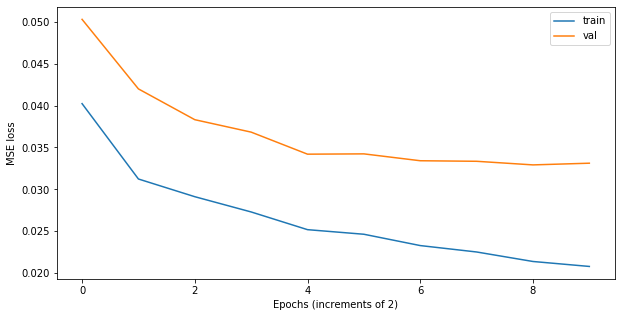

In [303]:
figSize(5, 10)

plt.figure()
for i, label in enumerate(['train', 'val']):
    plt.plot(loss_curves[i], label = label)

plt.legend()
plt.ylabel('MSE loss')
plt.xlabel('Epochs (increments of ' + str(print_every) + ')')
plt.show()

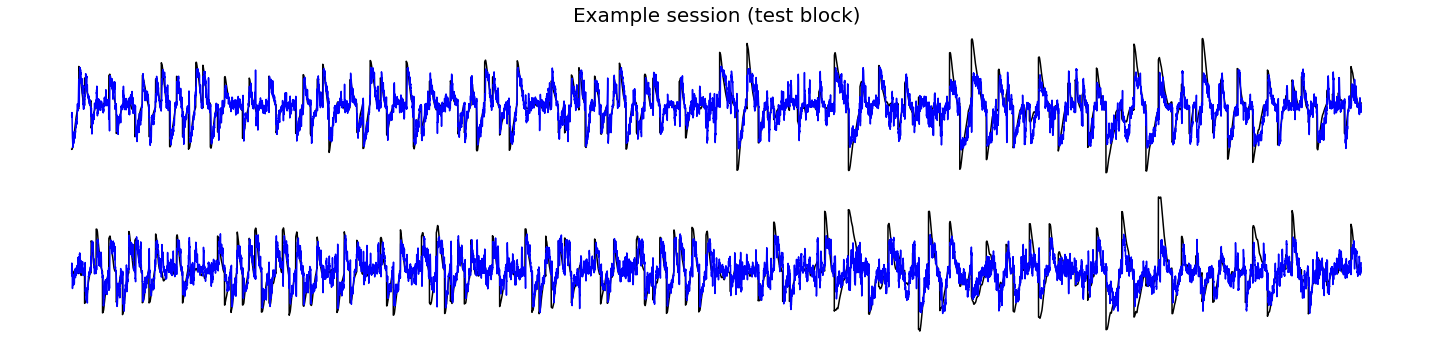

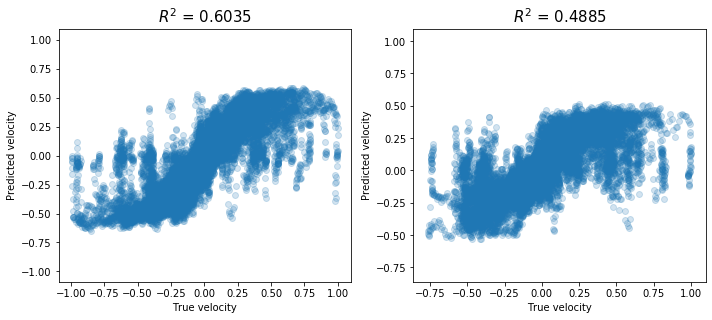

In [304]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

model.eval()
preds  = model_utils.predictRNN(model, x_val, y_val, DEVICE = DEVICE)

figSize(5, 20)

plt.figure(1)
trl = 0

for i in range(output_size):
    x = y_val[trl][:, i]
    y = preds[trl].squeeze()[:, i]
    
    plt.subplot(output_size, 1, i + 1)
    _ = plt.plot(x, color = 'k')
    plt.axis('off')
    _ = plt.plot(y, color = 'b')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.suptitle('Example session (test block)', fontsize = 20)

figSize(5, 10)

plt.figure(2)
for i in range(output_size):
    x = y_val[trl][:, i]
    y = preds[trl].squeeze()[:, i]
    
    plt.subplot(1, 2,  i + 1)
    plt.scatter(x, y, alpha = 0.2)
    minval = min(x.min(), y.min()) - 0.1
    maxval = max(x.max(), y.max()) + 0.1
    plt.xlim([minval, maxval])
    plt.ylim([minval, maxval])
    plt.xlabel('True velocity')
    plt.ylabel('Predicted velocity')
    plt.title('$R^2$ = ' + str(np.round(r2_score(x, y), 4)), fontsize = 15)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.show()

### test RNN and linear decoder on each day

In [249]:
import model_utils

np.random.seed(42)       # make reproducible
torch.manual_seed(42)    # make reproducible

# Get initial day performance and decoder:
cfg = dict()
cfg['train_size'] = 0.67
cfg['task']       = None
cfg['blocks']     = None
cfg['sigma']      = 2
cfg['seqlen']     = 300


scores_dict = dict()
scores_dict['RNN']    = np.zeros((len(files), ))
scores_dict['linear'] = np.zeros((len(files), ))

for i, file in enumerate(files):

    x_train, y_train, x_val, y_val = prepareSessionForRNN(file, cfg)
    torch.cuda.empty_cache()

    input_size    = 192
    hidden_size   = 20
    output_size   = 2
    n_layers      = 1
    dropout       = 0.5

    model       = models.LSTM2(input_size, hidden_size, output_size, n_layers = n_layers, dropout = dropout).double()
    loss_fcn    = torch.nn.MSELoss(reduction= 'mean')
    optimizer   = torch.optim.Adam(model.parameters(), lr= 0.008)
    DEVICE      = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
    model.to(DEVICE)
    
    # train RNN:
    n_epochs    = 10
    batch_size  = 50

    for epoch in range(n_epochs):
        model_utils.trainRNN(model, loss_fcn, optimizer, x_train, y_train, batch_size = batch_size, ignore_index = 0, shuffle = True, DEVICE = DEVICE, addNoise = 0.)

    # get RNN score:
    model.eval()
    preds                 = model_utils.predictRNN(model, x_val, y_val, DEVICE = DEVICE)
    scores_dict['RNN'][i] = r2_score(y_val[0], preds[0].squeeze(), multioutput = 'variance_weighted')
    
    # get linear regression score: 
    ref_decoder              = LinearRegression(normalize = False).fit(np.concatenate(x_train), np.concatenate(y_train))
    scores_dict['linear'][i] = ref_decoder.score(x_val[0], y_val[0])
    
    if (i + 1) % 10 == 0:
        print((i + 1), '/', len(files) )

/share/software/user/open/py-scikit-learn/0.19.1_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


10 / 61
20 / 61
30 / 61
40 / 61
50 / 61
60 / 61


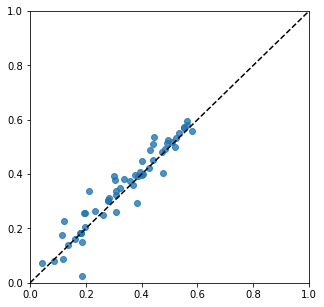

In [250]:
figSize(5, 5)

plt.scatter(scores_dict['linear'], scores_dict['RNN'], alpha = 0.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'k')
plt.show()

In [312]:
np.median(scores_dict['RNN'] - scores_dict['linear']) 

0.013837711633612526